## Figure 2 code
Elena Savidge
<br>
30 Oct 2024

In [1]:
# # load packages
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC
import cmocean
import scipy
from scipy import ndimage
import cartopy.crs as ccrs
import cartopy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import numpy as np
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import rasterio
from rasterio.plot import show
import pyproj
from pyproj import Proj, transform, CRS
#import rioxarray as rxr
import geopandas as gpd
import datetime
from osgeo import gdal
from shapely.geometry import Point, Polygon
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import geopandas as gpd
from skimage import exposure
import pandas as pd
import matplotlib.pyplot as plt
import datetime

/opt/anaconda3/envs/polyarea/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
# need this line for pyproj to work
pyproj.datadir.set_data_dir('/opt/anaconda3/envs/polyarea/share/proj') 

## Read in grounding line

In [3]:
# Define your points and create a bounding box polygon
p1 = Point(-110, -70.5)
p2 = Point(-111.7, -75.4)
p3 = Point(-98.0, -75.4)
p4 = Point(-99.5, -70.5)

# Define the bounding box CRS
crs = "EPSG:4326"  # Adjust this based on your data's CRS
bb_polygon = Polygon([p1, p2, p3, p4])
map_extent = gpd.GeoDataFrame(geometry=[bb_polygon], crs=crs)

# Read in the coastline with a defined CRS
coastline = '../add_coastline_high_res_line_v7_4.shp'  #version 7.4 is updated
shelf = gpd.read_file(coastline)

# Make sure both GeoDataFrames have the same CRS
shelf = shelf.to_crs(crs)

# Check the intersection
intersection = map_extent.intersects(shelf.unary_union)
print("Intersection:", intersection)

# Clip with the same CRS
shelf_clip = gpd.clip(shelf, map_extent)
shelf_clip = shelf_clip[~shelf_clip.is_empty]
# land = shelf_clip.loc[shelf_clip['surface'] == 'land']
# ice = shelf_clip.loc[shelf_clip['surface'] == 'ice shelf']
GL = shelf_clip.loc[shelf_clip['surface'] == 'grounding line']

# Print lengths to verify
print("Length of original shelf:", len(shelf))
print("Length of clipped shelf:", len(shelf_clip))
# print("Length of land:", len(land))
# print("Length of ice:", len(ice))
print("Length of GL:", len(GL))

Intersection: 0    True
dtype: bool
Length of original shelf: 30663
Length of clipped shelf: 212
Length of GL: 43


### To resolve issue with new Sentinel-2 data download missing crs (get it from old image --> same tile = same bounds = same CRS)

Sentinel-2 data can be downloaded here:
https://browser.dataspace.copernicus.eu/?zoom=5&lat=50.16282&lng=20.78613&themeId=DEFAULT-THEME&visualizationUrl=U2FsdGVkX1%2FmHIsPn%2BXfhahaj9BRImmmIj6RspyvyEGGPZYgr34W6V7S9eb7KcDgIMNjtxwzdQd4RherUl%2FUPX1PoVy%2B7SqkUalH2N4roxDWsDceAsFiuEdOigdhU1jy&datasetId=S2_L2A_CDAS&demSource3D=%22MAPZEN%22&cloudCoverage=30&dateMode=SINGLE

### scene 2018/03/07

In [4]:
# Specify the path to a Sentinel-2 band file (e.g., B04 for red band)
band_path = '../PIG_sentinel2/20180307/S2B_MSIL1C_20180307T145249_N0206_R053_T14CMB_20180307T191420-ql.jpg'

# Open the band file
with rasterio.open(band_path) as dataset:
    # Get the CRS information
    crs_info = dataset.crs

# Print the CRS information
# print("CRS Info:")
# print(crs_info)

/opt/anaconda3/envs/polyarea/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [5]:
# file crs works but not rr--- exact same image tile so crs is the same

file_path = '../PIG_sentinel2/L1C_T14CMB_A015809_20200316T145252.tif'

# Normalize each band independently
def normalize_band(band):
    band_min = band.min()
    band_max = band.max()
    return ((band - band_min) / (band_max - band_min) * 255).astype('uint8')

# Open the single band
with rasterio.open(file_path) as file:
    # Read each band
    red_band = file.read(1)
    green_band = file.read(2)
    blue_band = file.read(3)

## Panels (a), (b), and (c)

## scene 1

In [6]:
# sentinel2: blue (B2), green (B3), red (B4)

red_path= '../PIG_sentinel2/20180307/T14CMB_20180307T145249_B04.jp2'
green_path= '../PIG_sentinel2/20180307/T14CMB_20180307T145249_B03.jp2'
blue_path= '../PIG_sentinel2/20180307/T14CMB_20180307T145249_B02.jp2'

# Normalize each band independently
def normalize_band(band):
    band_min = band.min()
    band_max = band.max()
    return ((band - band_min) / (band_max - band_min) * 255).astype('uint8')

# Open the single band
with rasterio.open(red_path) as rr, rasterio.open(green_path) as gg, rasterio.open(blue_path) as bb:
    # Read each band
    red_band = rr.read(1)
    green_band = gg.read(1)
    blue_band = bb.read(1)

    # Normalize each band
    red_band_normalized = normalize_band(red_band)
    green_band_normalized = normalize_band(green_band)
    blue_band_normalized = normalize_band(blue_band)

    # Stack the bands into an RGB image
    rgb_image = np.dstack((red_band_normalized, green_band_normalized, blue_band_normalized))

    # Get the geospatial transformation matrix
    transform = file.transform  # Assumes all bands share the same transform

    # Specify the South Polar Stereographic projection
    projection = ccrs.SouthPolarStereo(central_longitude=-99.0)  #get central lon from metadata

    # Calculate the geographic coordinates of the four corners
    width, height = file.width, file.height
    upper_left = transform * (0, 0)
    upper_right = transform * (width, 0)
    lower_left = transform * (0, height)
    lower_right = transform * (width, height)

    # Get corners in the desired projection
    ul_lon, ul_lat = projection.transform_point(upper_left[0], upper_left[1], file.crs)
    ur_lon, ur_lat = projection.transform_point(upper_right[0], upper_right[1], file.crs)
    ll_lon, ll_lat = projection.transform_point(lower_left[0], lower_left[1], file.crs)
    lr_lon, lr_lat = projection.transform_point(lower_right[0], lower_right[1], file.crs)


In [7]:
# Apply higher contrast stretching to each color channel
# It calculates the 1st and 95th percentiles of pixel values in each channel and stretches 
# the pixel values to cover the full range between these percentiles
def contrast_stretching(image):
    p1, p95 = np.percentile(image, (1, 95))  # Adjust the percentiles to control the contrast
    return exposure.rescale_intensity(image, in_range=(p1, p95))

red_band_stretched = contrast_stretching(rgb_image[:, :, 0])
green_band_stretched = contrast_stretching(rgb_image[:, :, 1])
blue_band_stretched = contrast_stretching(rgb_image[:, :, 2])

# Apply gamma correction to each color channel
# It applies a power-law transformation to the pixel values, effectively adjusting the brightness of the image.
#A gamma value of 3.5 is used in the code, which has the effect of darkening shadows and enhancing mid-tones and highlights.
def gamma_correction(image, gamma=2):
    return exposure.adjust_gamma(image, gamma)

red_band_corrected = gamma_correction(red_band_stretched)
green_band_corrected = gamma_correction(green_band_stretched)
blue_band_corrected = gamma_correction(blue_band_stretched)

# Stack the corrected channels back into an RGB image
rgb_image_corrected1 = np.stack((red_band_corrected, green_band_corrected, blue_band_corrected), axis=-1)

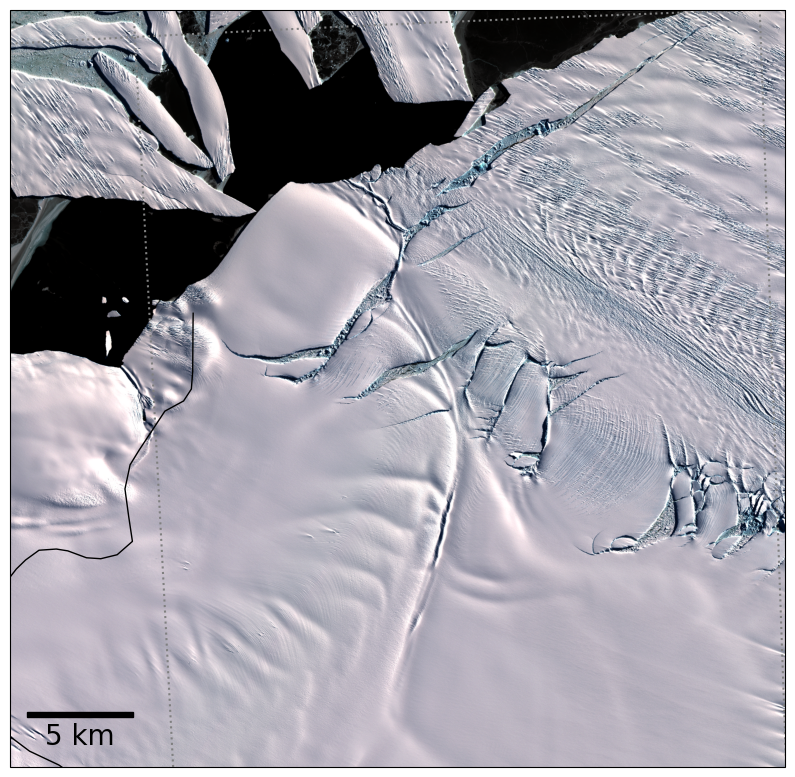

In [8]:
# Define the corner coordinates for the plot extent
llcrnrlat = -75.3
urcrnrlat = -75.0
llcrnrlon = -102.2
urcrnrlon = -101.0

# Create the plot with the specified CRS
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})

# Set the extent of the plot
ax.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], crs=ccrs.PlateCarree())

# Display the Landsat image with enhanced properties
data0 = ax.imshow(rgb_image_corrected1, 
                  extent=(ll_lon, ur_lon, ll_lat, ur_lat), 
                  origin='upper', 
                  transform=projection)
# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, xlocs=[-102, -101, -100, -99], ylocs=[-75.5, -75, -74.5, -74, -72], color='grey', linestyle=':',linewidth=1.5)

# Add the grounding line to the plot
ax.add_geometries(GL['geometry'], 
                  crs=ccrs.PlateCarree(), 
                  facecolor='None', 
                  edgecolor='k', 
                  zorder=3)

# Add a scale bar
fontprops = fm.FontProperties(size=20)
scalebar = AnchoredSizeBar(ax.transData,
                           5000, '5 km', 'lower left',
                           pad=0.5,
                           color='k',
                           frameon=False,
                           size_vertical=250,
                           fill_bar=True,
                           sep=3.5,
                           fontproperties=fontprops)
ax.add_artist(scalebar)

# Turn off axis visibility if needed
# ax.axis('off')

# Show the plot or save it as a PNG file
# plt.show()
#plt.savefig('sentinelpanela_31oct.png', format='png', dpi=400)


## scene 2

In [9]:
# sentinel2: blue (B2), green (B3), red (B4)

# red_path= 'PIG_sentinel2/20231113/T14CMB_20231113T144249_B04_10m.jp2'
# green_path= 'PIG_sentinel2/20231113/T14CMB_20231113T144249_B03_10m.jp2'
# blue_path= 'PIG_sentinel2/20231113/T14CMB_20231113T144249_B02_10m.jp2'

red_path= '../PIG_sentinel2/20231213/T14CMB_20231213T144249_B04_10m.jp2'
green_path= '../PIG_sentinel2/20231213/T14CMB_20231213T144249_B03_10m.jp2'
blue_path= '../PIG_sentinel2/20231213/T14CMB_20231213T144249_B02_10m.jp2'

# Normalize each band independently
def normalize_band(band):
    band_min = band.min()
    band_max = band.max()
    return ((band - band_min) / (band_max - band_min) * 255).astype('uint8')

# Open the single band
with rasterio.open(red_path) as rr, rasterio.open(green_path) as gg, rasterio.open(blue_path) as bb:
    # Read each band
    red_band = rr.read(1)
    green_band = gg.read(1)
    blue_band = bb.read(1)

    # Normalize each band
    red_band_normalized = normalize_band(red_band)
    green_band_normalized = normalize_band(green_band)
    blue_band_normalized = normalize_band(blue_band)

    # Stack the bands into an RGB image
    rgb_image = np.dstack((red_band_normalized, green_band_normalized, blue_band_normalized))

    # Get the geospatial transformation matrix
    transform = file.transform  # Assumes all bands share the same transform

    # Specify the South Polar Stereographic projection
    projection = ccrs.SouthPolarStereo(central_longitude=-99.0)  #get central lon from metadata

    # Calculate the geographic coordinates of the four corners
    width, height = file.width, file.height
    upper_left = transform * (0, 0)
    upper_right = transform * (width, 0)
    lower_left = transform * (0, height)
    lower_right = transform * (width, height)

    # Get corners in the desired projection
    ul_lon, ul_lat = projection.transform_point(upper_left[0], upper_left[1], file.crs)
    ur_lon, ur_lat = projection.transform_point(upper_right[0], upper_right[1], file.crs)
    ll_lon, ll_lat = projection.transform_point(lower_left[0], lower_left[1], file.crs)
    lr_lon, lr_lat = projection.transform_point(lower_right[0], lower_right[1], file.crs)


In [10]:
# Apply higher contrast stretching to each color channel
# It calculates the 1st and 99th percentiles of pixel values in each channel and stretches 
# the pixel values to cover the full range between these percentiles
def contrast_stretching(image):
    p1, p99 = np.percentile(image, (1, 99))  # Adjust the percentiles to control the contrast
    return exposure.rescale_intensity(image, in_range=(p1, p99))

red_band_stretched = contrast_stretching(rgb_image[:, :, 0])
green_band_stretched = contrast_stretching(rgb_image[:, :, 1])
blue_band_stretched = contrast_stretching(rgb_image[:, :, 2])

# Apply gamma correction to each color channel
# It applies a power-law transformation to the pixel values, effectively adjusting the brightness of the image.
#A gamma value of 3.5 is used in the code, which has the effect of darkening shadows and enhancing mid-tones and highlights.
def gamma_correction(image, gamma=2):
    return exposure.adjust_gamma(image, gamma)

red_band_corrected = gamma_correction(red_band_stretched)
green_band_corrected = gamma_correction(green_band_stretched)
blue_band_corrected = gamma_correction(blue_band_stretched)

# Stack the corrected channels back into an RGB image
rgb_image_corrected2 = np.stack((red_band_corrected, green_band_corrected, blue_band_corrected), axis=-1)

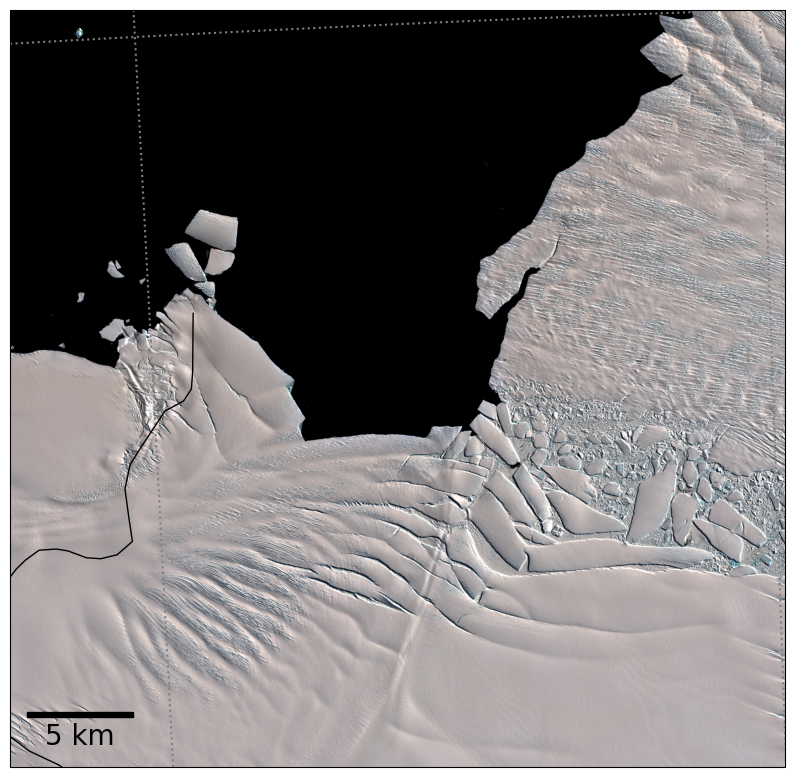

In [11]:
# Define the corner coordinates for the plot extent
llcrnrlat = -75.3
urcrnrlat = -75.0
llcrnrlon = -102.2
urcrnrlon = -101.0

# Create the plot with the specified CRS
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})

# Set the extent of the plot
ax.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], crs=ccrs.PlateCarree())

# Display the Landsat image with enhanced properties
data0 = ax.imshow(rgb_image_corrected2, 
                  extent=(ll_lon, ur_lon, ll_lat, ur_lat), 
                  origin='upper', 
                  transform=projection)
# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, xlocs=[-102, -101, -100, -99], ylocs=[-75.5, -75, -74.5, -74, -72], color='grey', linestyle=':',linewidth=1.5)

# Add the grounding line to the plot
ax.add_geometries(GL['geometry'], 
                  crs=ccrs.PlateCarree(), 
                  facecolor='None', 
                  edgecolor='k', 
                  zorder=3)

# Add a scale bar
fontprops = fm.FontProperties(size=20)
scalebar = AnchoredSizeBar(ax.transData,
                           5000, '5 km', 'lower left',
                           pad=0.5,
                           color='k',
                           frameon=False,
                           size_vertical=250,
                           fill_bar=True,
                           sep=3.5,
                           fontproperties=fontprops)
ax.add_artist(scalebar)

# Turn off axis visibility if needed
# ax.axis('off')

# Show the plot or save it as a PNG file
# plt.show()
#plt.savefig('sentinelpanelb_31oct.png', format='png', dpi=400)

## Load coastline shapefiles

In [12]:
coast2017 = gpd.read_file('../deformation tiffs (qgis)/digitization/20171013coastline.shp')
coast2017 = coast2017.to_crs("epsg:4326")

coast2018 = gpd.read_file('../deformation tiffs (qgis)/digitization/20181118coastline.shp')
coast2018 = coast2018.to_crs("epsg:4326")

coast2020 = gpd.read_file('../deformation tiffs (qgis)/digitization/20200211coastline.shp')
coast2020 = coast2020.to_crs("epsg:4326")

In [13]:
# large bounding box
smallbbox = gpd.read_file('../deformation tiffs (qgis)/digitization/smallbbox.shp')
# convert coordinate system (utm to latlon)
smallbbox = smallbbox.to_crs("epsg:4326")

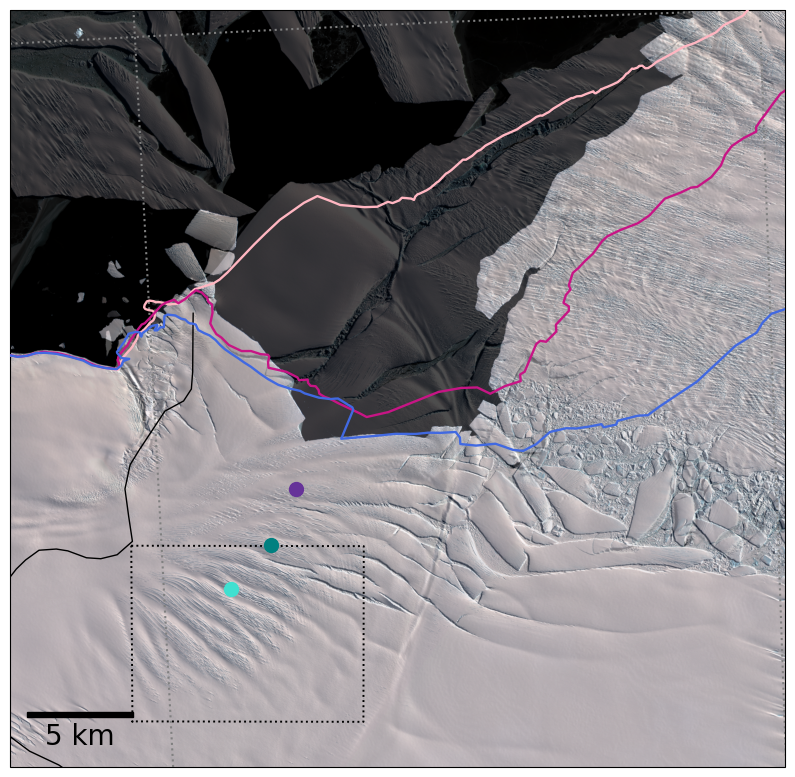

In [14]:
#llcrnrlat=-75.35;urcrnrlat=-74.9;llcrnrlon=-101.8;urcrnrlon=-99.7
#llcrnrlat=-75.34;urcrnrlat=-74.8;llcrnrlon=-102.3;urcrnrlon=-99
llcrnrlat=-75.3;urcrnrlat=-75;llcrnrlon=-102.2;urcrnrlon=-101
# Create the plot with the specified CRS
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})

# Set the extent
ax.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], crs=ccrs.PlateCarree())

# Display the Landsat image with improved brightness, higher contrast, and gamma correction
data0 = ax.imshow(rgb_image_corrected1, extent=(ll_lon, ur_lon, ll_lat, ur_lat), origin='upper',transform=projection,)
data = ax.imshow(rgb_image_corrected2, extent=(ll_lon, ur_lon, ll_lat, ur_lat), origin='upper',transform=projection, alpha=0.7, zorder=2)
#strain = ax.imshow(effective_strain[75,:,:], extent=(ll_lon_strain, ur_lon_strain, ll_lat_strain, ur_lat_strain),vmin =0, vmax = 1, cmap = 'Reds',transform=projection2,alpha=0.4)

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, xlocs=[-102, -101, -100, -99], ylocs=[-75.5, -75, -74.5, -74, -72], color='grey', linestyle=':',linewidth=1.5)
#gl.top_labels = gl.right_labels = False  # Turn off top and right labels

#ax.add_geometries(GL['geometry'], crs=ccrs.PlateCarree(),facecolor='None', edgecolor='red',linewidth=3)
ax.add_geometries(GL['geometry'], crs=ccrs.PlateCarree(),facecolor='None', edgecolor='k',zorder=3)
ax.add_geometries(smallbbox['geometry'], crs=ccrs.PlateCarree(),facecolor='None', linestyle=':',edgecolor='k',zorder=3,linewidth=1.4)

# coastlines
ax.add_geometries(coast2017['geometry'], crs=ccrs.PlateCarree(),facecolor='None', edgecolor='lightpink',zorder=5,label='13 Oct 2017 coastline',linewidth=1.7)
ax.add_geometries(coast2018['geometry'], crs=ccrs.PlateCarree(),facecolor='None', edgecolor='mediumvioletred',zorder=5,label='18 Nov 2018 coastline',linewidth=1.7)
ax.add_geometries(coast2020['geometry'], crs=ccrs.PlateCarree(),facecolor='None', edgecolor='royalblue',zorder=5,label='11 Feb 2020 coastline',linewidth=1.7)


ax.scatter(-101.7774,-75.1903, transform=ccrs.PlateCarree(), s=100, c='rebeccapurple',zorder=4)
ax.scatter(-101.8234,-75.2128, transform=ccrs.PlateCarree(), s=100, c='teal',zorder=4)
ax.scatter(-101.8903,-75.2305, transform=ccrs.PlateCarree(), s=100, c='turquoise',zorder=4)

# Colorbar
# cb = plt.colorbar(strain, fraction=0.04, pad=0.03)
# cb.set_label('Strain', fontsize=14, labelpad=5)

fontprops = fm.FontProperties(size=20)
scalebar = AnchoredSizeBar(ax.transData,
                           5000, '5 km', 'lower left',
                           pad=0.5,
                           color='k',
                           frameon=False,
                           size_vertical=250,
                           fill_bar=True,
                           sep=3.5,
                           fontproperties=fontprops)
ax.add_artist(scalebar)

# # Define custom legend handles for the coastlines
# import matplotlib.patches as mpatches
# from matplotlib.font_manager import FontProperties

# legend_handles = [
#     mpatches.Patch(color='lightpink', label='13 Oct 2017 coastline'),
#     mpatches.Patch(color='mediumvioletred', label='18 Nov 2018 coastline'),
#     mpatches.Patch(color='darkmagenta', label='11 Feb 2020 coastline')
# ]

# # Create a FontProperties object for Times New Roman, adjusting the size as needed
# legend_font = FontProperties(family='Times New Roman', size=14)
# # Add the custom legend handles to the legend with the specified font properties
# plt.legend(handles=legend_handles, loc='upper left', prop=legend_font)

# Turn off axis
#ax.axis('off')

#plt.show()

#plt.savefig('sentineloverlay_31oct.png', format='png', dpi=400)

## Panel (d)

### Read its live velocity taken at three points (lat,lon)
(https://its-live.jpl.nasa.gov/)

In [15]:
# Specify the file path
f1 ='../itslive-data_21dec/LAT-75.1903--LON-101.7774.csv'
f2 ='../itslive-data_21dec/LAT-75.2128--LON-101.8234.csv'
f3 ='../itslive-data_21dec/LAT-75.2305--LON-101.8903.csv'

# Read the CSV file into a DataFrame
df1 = pd.read_csv(f1)
df2 = pd.read_csv(f2)
df3 = pd.read_csv(f3)

# Display the DataFrame
df1.head(5)

mid_date      lat       lon  v [m/yr]  v_error [m/yr]  \
0  2020-12-21 14:52:59.201121024 -75.1903 -101.7774    1194.0           170.0   
1  2021-11-10 08:47:06.302012160 -75.1903 -101.7774    1426.0            72.0   
2  2020-12-22 15:12:59.201117184 -75.1903 -101.7774    1280.0            15.0   
3  2020-01-01 14:52:49.191226880 -75.1903 -101.7774    1019.0           104.0   
4  2016-12-13 15:12:57.161202688 -75.1903 -101.7774     765.0            27.0   

   vx [m/yr]  vx_error [m/yr]  vy [m/yr]  vy_error [m/yr]  date_dt [days]  \
0    -1111.0            181.5      438.0             56.2              60   
1    -1368.0             71.6      400.0             82.0               6   
2    -1207.0             15.4      425.0             12.7              70   
3     -939.0            107.8      396.0             76.5              10   
4     -750.0             25.9      152.0             39.0              19   

  mission satellite  epsg  
0       S        2B  3031  
1       S        1B  3031  
2       S        2B  3031  
3       S        2B  3031  
4       S        2A  3031

In [16]:
df1.mid_date

0      2020-12-21 14:52:59.201121024
1      2021-11-10 08:47:06.302012160
2      2020-12-22 15:12:59.201117184
3      2020-01-01 14:52:49.191226880
4      2016-12-13 15:12:57.161202688
                   ...              
659    2018-11-28 07:27:23.192055040
660    2022-01-17 14:58:11.182771968
661    2022-03-05 14:39:57.745338624
662    2022-02-09 14:40:01.090178048
663    2022-01-05 14:58:21.408416000
Name: mid_date, Length: 664, dtype: object

In [17]:
#from datetime import datetime

# Convert the 'datetime_column' to datetime format
df1['date'] = pd.to_datetime(df1['mid_date'])
# Extract the date part in the desired format
df1['date'] = df1['date'].dt.strftime("%Y-%m-%d")
df1 = df1.sort_values(by='date') 

# Convert the 'datetime_column' to datetime format
df2['date'] = pd.to_datetime(df2['mid_date'])
# Extract the date part in the desired format
df2['date'] = df2['date'].dt.strftime("%Y-%m-%d")
df2 = df2.sort_values(by='date') 

# Convert the 'datetime_column' to datetime format
df3['date'] = pd.to_datetime(df3['mid_date'])
# Extract the date part in the desired format
df3['date'] = df3['date'].dt.strftime("%Y-%m-%d")
df3 = df3.sort_values(by='date') 

In [18]:
# concat all dfs
dfs = pd.concat([df1,df2,df3])
# Convert the 'date' column to datetime format
dfs['date'] = pd.to_datetime(dfs['date'])

# Specify the date to split the data -- 2018 calving event
split_date = pd.to_datetime('2018-10-28')

# Separate data before and after the split date
df_before = dfs[dfs['date'] < split_date]
df_after = dfs[dfs['date'] >= split_date]

# Remove rows with NaN values in 'v [m/yr]'
df_before = df_before.dropna(subset=['v [m/yr]'])
df_after = df_after.dropna(subset=['v [m/yr]'])

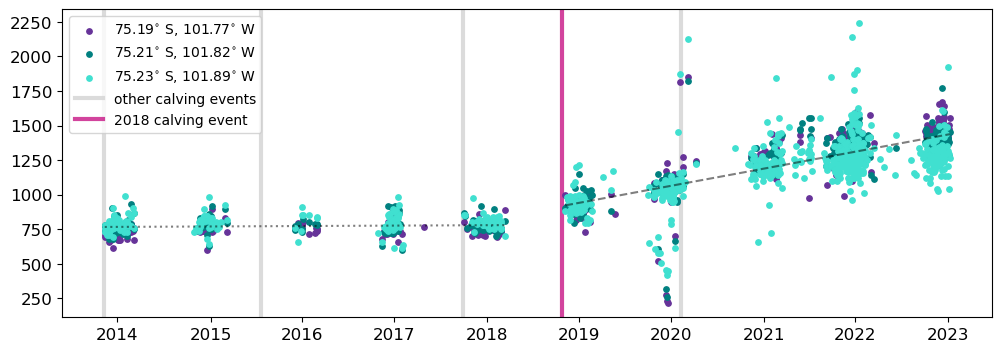

In [19]:
# Convert the 'date' column to datetime format
df1['date'] = pd.to_datetime(df1['date'])

plt.figure(figsize=(12, 4))
plt.scatter(df1['date'], df1['v [m/yr]'],s=15,c='rebeccapurple',label='75.19$^{\circ}$ S, 101.77$^{\circ}$ W')
plt.scatter(df2['date'], df2['v [m/yr]'],s=15,c='teal',label='75.21$^{\circ}$ S, 101.82$^{\circ}$ W')
plt.scatter(df3['date'], df3['v [m/yr]'],s=15,c='turquoise',label = '75.23$^{\circ}$ S, 101.89$^{\circ}$ W')

# calving events
# plt.axvline(datetime.datetime(2001, 11, 11),c='lightgrey',alpha=0.8,linewidth=3, label = 'calving event')
# plt.axvline(datetime.datetime(2007, 9, 29),c='lightgrey',alpha=0.8,linewidth=3)
plt.axvline(datetime.datetime(2013, 11, 11),c='lightgrey',alpha=0.8,linewidth=3,zorder=0)
plt.axvline(datetime.datetime(2015, 7, 25),c='lightgrey',alpha=0.8,linewidth=3,zorder=0)
plt.axvline(datetime.datetime(2017, 10, 1),c='lightgrey',alpha=0.8,linewidth=3,zorder=0, label='other calving events')
plt.axvline(datetime.datetime(2018, 10, 28),c='mediumvioletred',alpha=0.8,linewidth=3, label = '2018 calving event',zorder=0)
plt.axvline(datetime.datetime(2020, 2, 10),c='lightgrey',alpha=0.8,linewidth=3,zorder=0)

# Polynomial regression for points before the split date
degree_before = 1  # Adjust the degree as needed
years_before = (df_before['date'] - df_before['date'].min()).dt.days / 365.25  # Calculate years since the beginning
coeff_before = np.polyfit(years_before, df_before['v [m/yr]'], degree_before)
poly_before = np.poly1d(coeff_before)
plt.plot(df_before['date'], poly_before(years_before), color='k', linestyle=':',alpha=0.5)

# Polynomial regression for points after the split date
degree_after = 1  # Adjust the degree as needed
years_after = (df_after['date'] - split_date).dt.days / 365.25  # Calculate years since the split_date
coeff_after = np.polyfit(years_after, df_after['v [m/yr]'], degree_after)
poly_after = np.poly1d(coeff_after)
plt.plot(df_after['date'], poly_after(years_after), color='k', linestyle='--',alpha=0.5)

# Get the current axis
ax = plt.gca()

# Get the first data point of each year
first_point_of_year = df1.groupby(df1['date'].dt.year)['date'].first()

# Exclude the first label for the year 2013
first_point_of_year = first_point_of_year[first_point_of_year.index != 2013]

# Set format of labels
labels = [i.strftime("%Y") for i in first_point_of_year]

# Now set the ticks and labels
ax.set_xticks(first_point_of_year)
ax.set_xticklabels(labels,fontsize=12)  # Rotate and adjust alignment for better readability

# plt.xlabel('time',fontsize=15)
# plt.ylabel('ice flow speed [m/yr]',fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=10,loc='upper left')
#plt.show()

#plt.savefig('2018_southshelfspeed_increase_v2.png', format='png', dpi=400)

## Supplement figs
To run, uncomment

## Test with different break points 
The ice flow speed slope changed at some time between 2018 and 2019.5, here we want to test with different breakpoints in time to see where that change happened and how that breakpoint impacts the acceleration we calculate
<br><br>
One per month between 1 Jan 2018 and 1 Jan 2019

In [8]:
# # Assuming dfs is your DataFrame and 'date' is in datetime format

# # Define start and end dates for the range within which to test breakpoints
# start_date = pd.to_datetime('2017-10-01')
# end_date = pd.to_datetime('2018-11-01')

# # Generate a list of monthly breakpoints between start and end dates
# breakpoints = pd.date_range(start=start_date, end=end_date, freq='MS')

# # Placeholder for polynomial coefficients and factor of increase
# coefficients = []

# # Iterate through each split_date
# for split_date in breakpoints:
#     # Split the data
#     df_before = dfs[dfs['date'] < split_date].dropna(subset=['v [m/yr]'])
#     df_after = dfs[dfs['date'] >= split_date].dropna(subset=['v [m/yr]'])
    
#     # Convert dates to years since the earliest date in each subset for regression analysis
#     years_before = (df_before['date'] - df_before['date'].min()).dt.total_seconds() / (365.25*24*60*60)
#     years_after = (df_after['date'] - split_date).dt.total_seconds() / (365.25*24*60*60)
    
#     # Polynomial regression (first degree) for the period before the split_date
#     if len(df_before) > 1: # Ensure there are enough points for regression
#         coeff_before = np.polyfit(years_before, df_before['v [m/yr]'], 1)
#     else:
#         coeff_before = [np.nan, np.nan]
    
#     # Polynomial regression (first degree) for the period after the split_date
#     if len(df_after) > 1: # Ensure there are enough points for regression
#         coeff_after = np.polyfit(years_after, df_after['v [m/yr]'], 1)
#     else:
#         coeff_after = [np.nan, np.nan]
    
#     # Calculate factor of increase
#     if coeff_before[0] != 0 and not np.isnan(coeff_before[0]) and not np.isnan(coeff_after[0]):
#         factor_increase = coeff_after[0] / coeff_before[0]
#     else:
#         factor_increase = np.nan
    
#     # Store the coefficients and factor of increase
#     coefficients.append({'split_date': split_date, 'coeff_before': coeff_before, 'coeff_after': coeff_after, 'factor_increase': factor_increase})

# # Convert the coefficients list to a DataFrame for easier analysis
# coefficients_df = pd.DataFrame(coefficients)

# # Now, coefficients_df contains the slope and intercept for each period before and after each split_date, along with the factor of increase in slope
# coefficients_df 

split_date                             coeff_before  \
0  2017-10-01    [5.414027306466521, 765.096458897846]   
1  2017-11-01    [6.33289802291157, 764.4518581725711]   
2  2017-12-01   [5.181464363720144, 765.2982875751413]   
3  2018-01-01   [4.865757454730139, 765.5480890951761]   
4  2018-02-01   [5.284908780975163, 765.2152983192451]   
5  2018-03-01   [3.271698650006174, 766.8648759590186]   
6  2018-04-01  [3.0725332203084283, 767.0317189571967]   
7  2018-05-01  [3.0725332203084283, 767.0317189571967]   
8  2018-06-01  [3.0725332203084283, 767.0317189571967]   
9  2018-07-01  [3.0725332203084283, 767.0317189571967]   
10 2018-08-01  [3.0725332203084283, 767.0317189571967]   
11 2018-09-01  [3.0725332203084283, 767.0317189571967]   
12 2018-10-01  [3.0725332203084283, 767.0317189571967]   
13 2018-11-01  [3.0725332203084283, 767.0317189571967]   

                                coeff_after  factor_increase  
0   [128.31208151388827, 766.5839916342218]        23.699932  
1    [128.6229160032983, 776.2620464181445]        20.310277  
2   [128.46185882616285, 787.4473889537117]        24.792578  
3    [128.0987469549598, 799.7270218914981]        26.326579  
4   [127.82884468629821, 811.6020767157562]        24.187521  
5    [124.49587934412278, 833.584647466358]        38.052367  
6   [123.55462437061948, 847.5213726830765]        40.212624  
7   [123.55462437061934, 857.6695964506844]        40.212624  
8   [123.55462437061954, 868.1560943438789]        40.212624  
9   [123.55462437061941, 878.3043181114863]        40.212624  
10  [123.55462437061921, 888.7908160046807]        40.212624  
11   [123.5546243706195, 899.2773138978748]        40.212624  
12   [123.55462437061941, 909.425537665482]        40.212624  
13  [123.55462437061915, 919.9120355586762]        40.212624

In [9]:
# some numbers
#coefficients_df.mean(),coefficients_df.std(),coefficients_df.sem()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


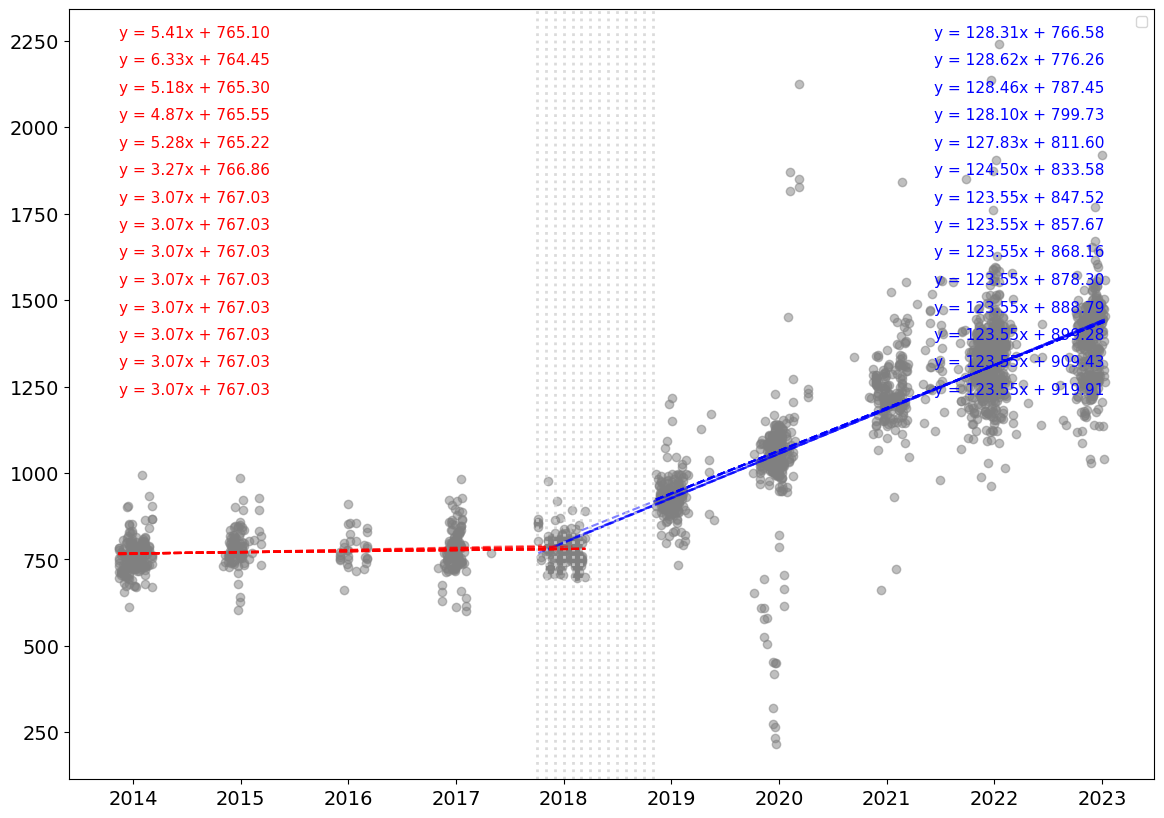

In [10]:
# # visualize this
# plt.figure(figsize=(14, 10))

# # Plot the original velocity data
# plt.scatter(dfs['date'], dfs['v [m/yr]'], color='grey', alpha=0.5)

# # Initialize y-coordinate for text annotations
# text_y_pos_before = plt.gca().get_ylim()[1]  # Start text at the top of the plot for 'before'
# text_y_pos_after = plt.gca().get_ylim()[1]  # Start text at the top of the plot for 'after'
# text_y_step = (plt.gca().get_ylim()[1] - plt.gca().get_ylim()[0]) / (len(coefficients_df) * 2)  # Step to space out text

# for i, row in coefficients_df.iterrows():
#     split_date = row['split_date']
#     coeff_before, coeff_after = row['coeff_before'], row['coeff_after']

#     # Prepare the text for polynomial equations
#     equation_before = f"y = {coeff_before[0]:.2f}x + {coeff_before[1]:.2f}"
#     equation_after = f"y = {coeff_after[0]:.2f}x + {coeff_after[1]:.2f}"
    
#     # Update the y-coordinate for text annotations
#     text_y_pos_before -= text_y_step
#     text_y_pos_after -= text_y_step
    
#     # Add text annotations for equations
#     plt.text(dfs['date'].min(), text_y_pos_before, equation_before, color='red', fontsize=11)
#     plt.text(dfs['date'].max(), text_y_pos_after, equation_after, color='blue', fontsize=11, horizontalalignment='right')

    
# # Assuming coefficients_df is prepared with 'split_date', 'coeff_before', 'coeff_after'
# for index, row in coefficients_df.iterrows():
#     split_date = row['split_date']
#     coeff_before = row['coeff_before']
#     coeff_after = row['coeff_after']
    
#     # Prepare the data for plotting
#     dates_before = dfs[dfs['date'] < split_date]['date']
#     dates_after = dfs[dfs['date'] >= split_date]['date']
#     years_before = (dates_before - dfs['date'].min()).dt.total_seconds() / (365.25 * 24 * 60 * 60)
#     years_after = (dates_after - split_date).dt.total_seconds() / (365.25 * 24 * 60 * 60)

#     # Plot regression lines
#     if not np.isnan(coeff_before).any():  # Check if coefficients are valid
#         line_before = np.poly1d(coeff_before)(years_before)
#         plt.plot(dates_before, line_before, color='red', linestyle='--', alpha=0.5)
#     if not np.isnan(coeff_after).any():  # Check if coefficients are valid
#         line_after = np.poly1d(coeff_after)(years_after)
#         plt.plot(dates_after, line_after, color='blue', linestyle='--', alpha=0.5)
        
#     # Mark the split date
#     plt.axvline(split_date, color='lightgrey', alpha=0.8, linewidth=2, linestyle=':')

# # plt.xlabel('Date')
# # plt.ylabel('Velocity [m/yr]')
# # plt.title('Velocity Data with Polynomial Regression Lines and Equations')
# plt.legend()
# plt.xticks(fontsize=14);plt.yticks(fontsize=14)
# plt.show()
# #plt.savefig('velocityslopeuncertainty.png', format='png', dpi=400)


## More supplement fig code
Here we are checking velocity at a different part of the south shelf and on the main trunk of PIGIS, for the same time interval

## 1. On main trunk

In [11]:
# # Specify the file path
# f1 ='../its_live_PIGsupplement/itslive-data_maintrunk/LAT-75.0245--LON-100.9137.csv'
# f2 ='../its_live_PIGsupplement/itslive-data_maintrunk/LAT-75.0561--LON-100.6787.csv'
# f3 ='../its_live_PIGsupplement/itslive-data_maintrunk/LAT-75.0883--LON-100.4455.csv'
# f4 ='../its_live_PIGsupplement/itslive-data_maintrunk/LAT-75.1287--LON-100.18.csv'

# # Read the CSV file into a DataFrame
# df1 = pd.read_csv(f1)
# df2 = pd.read_csv(f2)
# df3 = pd.read_csv(f3)
# df4 = pd.read_csv(f4)

# # Display the DataFrame
# df1.head(5)

mid_date      lat       lon  v [m/yr]  v_error [m/yr]  \
0  2021-04-02 08:46:57.215872000 -75.0245 -100.9137    5052.0            99.0   
1  2018-04-18 08:46:39.140258048 -75.0245 -100.9137    4206.0            75.0   
2  2019-01-29 04:35:21.802213632 -75.0245 -100.9137    4566.0            46.0   
3  2002-12-26 14:33:59.685139968 -75.0245 -100.9137    2835.0           141.0   
4  2018-01-24 08:46:38.661629952 -75.0245 -100.9137    4112.0            69.0   

   vx [m/yr]  vx_error [m/yr]  vy [m/yr]  vy_error [m/yr]  date_dt [days]  \
0    -1036.0             87.6    -4945.0             99.5               5   
1    -1932.0             67.5    -3736.0             77.0               5   
2    -1646.0             21.6    -4259.0             48.9              11   
3    -1504.0            141.0    -2403.0            141.0              65   
4    -1928.0             61.8    -3632.0             71.1               5   

  mission satellite  epsg  
0       S        1A  3031  
1       S        1A  3031  
2       S        1B  3031  
3       L         7  3031  
4       S        1A  3031

In [19]:
#df1.mid_date

In [13]:
# #from datetime import datetime

# # Convert the 'datetime_column' to datetime format
# df1['date'] = pd.to_datetime(df1['mid_date'])
# # Extract the date part in the desired format
# df1['date'] = df1['date'].dt.strftime("%Y-%m-%d")
# df1 = df1.sort_values(by='date') 

# # Convert the 'datetime_column' to datetime format
# df2['date'] = pd.to_datetime(df2['mid_date'])
# # Extract the date part in the desired format
# df2['date'] = df2['date'].dt.strftime("%Y-%m-%d")
# df2 = df2.sort_values(by='date') 

# # Convert the 'datetime_column' to datetime format
# df3['date'] = pd.to_datetime(df3['mid_date'])
# # Extract the date part in the desired format
# df3['date'] = df3['date'].dt.strftime("%Y-%m-%d")
# df3 = df3.sort_values(by='date') 

# # Convert the 'datetime_column' to datetime format
# df4['date'] = pd.to_datetime(df4['mid_date'])
# # Extract the date part in the desired format
# df4['date'] = df4['date'].dt.strftime("%Y-%m-%d")
# df4 = df4.sort_values(by='date') 


# # # Filter DataFrames to only include data from 2014 onwards
# df1 = df1[df1['date']>'2013-11-12'] #match start of other records
# df2 = df2[df2['date']>'2013-11-12']
# df3 = df3[df3['date']>'2013-11-12']
# df4 = df4[df4['date']>'2013-11-12']

(3500.0, 5500.0)

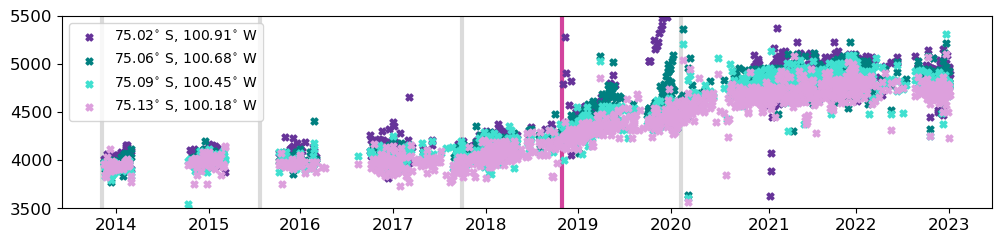

In [14]:
# # Vis

# # Convert the 'date' column to datetime format
# df1['date'] = pd.to_datetime(df1['date'])

# plt.figure(figsize=(12, 2.5))
# plt.scatter(df1['date'], df1['v [m/yr]'],s=25, marker= 'X',c='rebeccapurple',label='75.02$^{\circ}$ S, 100.91$^{\circ}$ W')
# plt.scatter(df2['date'], df2['v [m/yr]'],s=25, marker= 'X',c='teal',label='75.06$^{\circ}$ S, 100.68$^{\circ}$ W')
# plt.scatter(df3['date'], df3['v [m/yr]'],s=25, marker= 'X',c='turquoise',label = '75.09$^{\circ}$ S, 100.45$^{\circ}$ W')
# plt.scatter(df4['date'], df4['v [m/yr]'],s=25, marker= 'X',c='plum',label = '75.13$^{\circ}$ S, 100.18$^{\circ}$ W')

# # calving events
# # plt.axvline(datetime.datetime(2001, 11, 11),c='lightgrey',alpha=0.8,linewidth=3, label = 'calving event')
# # plt.axvline(datetime.datetime(2007, 9, 29),c='lightgrey',alpha=0.8,linewidth=3)
# plt.axvline(datetime.datetime(2013, 11, 11),c='lightgrey',alpha=0.8,linewidth=3,zorder=0)
# plt.axvline(datetime.datetime(2015, 7, 25),c='lightgrey',alpha=0.8,linewidth=3,zorder=0)
# plt.axvline(datetime.datetime(2017, 10, 1),c='lightgrey',alpha=0.8,linewidth=3,zorder=0, )
# plt.axvline(datetime.datetime(2018, 10, 28),c='mediumvioletred',alpha=0.8,linewidth=3,zorder=0)
# plt.axvline(datetime.datetime(2020, 2, 10),c='lightgrey',alpha=0.8,linewidth=3,zorder=0)


# # Get the current axis
# ax = plt.gca()

# # Get the first data point of each year
# first_point_of_year = df1.groupby(df1['date'].dt.year)['date'].first()

# # Exclude the first label for the year 2013
# first_point_of_year = first_point_of_year[first_point_of_year.index != 2013]

# # Set format of labels
# labels = [i.strftime("%Y") for i in first_point_of_year]

# # Now set the ticks and labels
# ax.set_xticks(first_point_of_year)
# ax.set_xticklabels(labels,fontsize=12)  # Rotate and adjust alignment for better readability
# ax.set_ylim([2000,8000])

# # # plt.xlabel('time',fontsize=15)
# # # plt.ylabel('ice flow speed [m/yr]',fontsize=15)
# plt.yticks(fontsize=12)
# plt.legend(fontsize=10,loc='upper left')
# plt.ylim([3500,5500])
# # #plt.show()


# #plt.savefig('velocitymaintrunk_matchyrange.png', format='png', dpi=400)

## 2. On another location on south shelf

In [15]:
# # Specify the file path
# f1 ='../its_live_PIGsupplement/itslive-data_southshelf_eastchannel2/LAT-75.247--LON-101.4293.csv'
# f2 ='../its_live_PIGsupplement/itslive-data_southshelf_eastchannel2/LAT-75.2704--LON-101.448.csv'
# f3 ='../its_live_PIGsupplement/itslive-data_southshelf_eastchannel2/LAT-75.2948--LON-101.4836.csv'

# # Read the CSV file into a DataFrame
# df1 = pd.read_csv(f1)
# df2 = pd.read_csv(f2)
# df3 = pd.read_csv(f3)

# # Display the DataFrame
# df1.head(5)

mid_date     lat       lon  v [m/yr]  v_error [m/yr]  \
0  2020-12-21 14:52:59.201121024 -75.247 -101.4293     286.0           178.0   
1  2018-08-01 05:07:59.952432896 -75.247 -101.4293     251.0            35.0   
2  2018-01-24 08:46:38.661629952 -75.247 -101.4293     314.0            62.0   
3  2021-11-10 08:47:06.302012160 -75.247 -101.4293     421.0            75.0   
4  2020-03-26 08:46:51.214582016 -75.247 -101.4293     324.0            76.0   

   vx [m/yr]  vx_error [m/yr]  vy [m/yr]  vy_error [m/yr]  date_dt [days]  \
0     -281.0            181.5      -55.0             56.2              60   
1     -250.0             33.4       24.0            105.6               5   
2     -312.0             61.8      -40.0             71.1               5   
3     -340.0             71.6     -248.0             82.0               6   
4     -319.0             75.5      -60.0             86.2               5   

  mission satellite  epsg  
0       S        2B  3031  
1       S        1A  3031  
2       S        1A  3031  
3       S        1B  3031  
4       S        1A  3031

In [20]:
#df1.mid_date

In [17]:
# from datetime import datetime

# # Convert the 'datetime_column' to datetime format
# df1['date'] = pd.to_datetime(df1['mid_date'])
# # Extract the date part in the desired format
# df1['date'] = df1['date'].dt.strftime("%Y-%m-%d")
# df1 = df1.sort_values(by='date') 

# # Convert the 'datetime_column' to datetime format
# df2['date'] = pd.to_datetime(df2['mid_date'])
# # Extract the date part in the desired format
# df2['date'] = df2['date'].dt.strftime("%Y-%m-%d")
# df2 = df2.sort_values(by='date') 

# # Convert the 'datetime_column' to datetime format
# df3['date'] = pd.to_datetime(df3['mid_date'])
# # Extract the date part in the desired format
# df3['date'] = df3['date'].dt.strftime("%Y-%m-%d")
# df3 = df3.sort_values(by='date') 

# # # Filter DataFrames to only include data from 2014 onwards
# df1 = df1[df1['date']>'2013-11-12'] #match start of other records
# df2 = df2[df2['date']>'2013-11-12']
# df3 = df3[df3['date']>'2013-11-12']

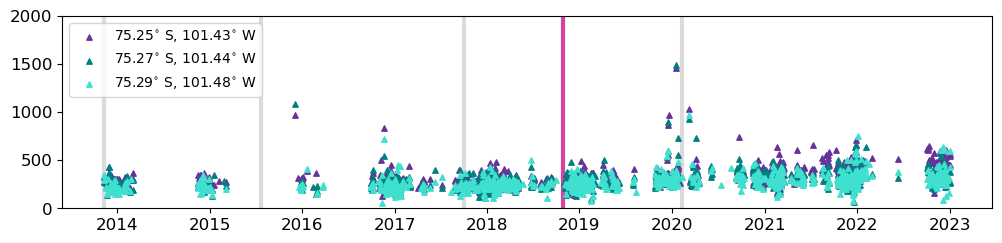

In [18]:
# # Vis
# import datetime

# # Convert the 'date' column to datetime format
# df1['date'] = pd.to_datetime(df1['date'])

# plt.figure(figsize=(12, 2.5))
# plt.scatter(df1['date'], df1['v [m/yr]'],s=15,marker= '^',c='rebeccapurple',label='75.25$^{\circ}$ S, 101.43$^{\circ}$ W')
# plt.scatter(df2['date'], df2['v [m/yr]'],s=15,marker= '^',c='teal',label='75.27$^{\circ}$ S, 101.44$^{\circ}$ W')
# plt.scatter(df3['date'], df3['v [m/yr]'],s=15,marker= '^',c='turquoise',label = '75.29$^{\circ}$ S, 101.48$^{\circ}$ W')

# # calving events
# # plt.axvline(datetime.datetime(2001, 11, 11),c='lightgrey',alpha=0.8,linewidth=3, label = 'calving event')
# # plt.axvline(datetime.datetime(2007, 9, 29),c='lightgrey',alpha=0.8,linewidth=3)
# plt.axvline(datetime.datetime(2013, 11, 11),c='lightgrey',alpha=0.8,linewidth=3,zorder=0)
# plt.axvline(datetime.datetime(2015, 7, 25),c='lightgrey',alpha=0.8,linewidth=3,zorder=0)
# plt.axvline(datetime.datetime(2017, 10, 1),c='lightgrey',alpha=0.8,linewidth=3,zorder=0)
# plt.axvline(datetime.datetime(2018, 10, 28),c='mediumvioletred',alpha=0.8,linewidth=3,zorder=0)
# plt.axvline(datetime.datetime(2020, 2, 10),c='lightgrey',alpha=0.8,linewidth=3,zorder=0)


# # Get the current axis
# ax = plt.gca()

# # Get the first data point of each year
# first_point_of_year = df1.groupby(df1['date'].dt.year)['date'].first()

# # Exclude the first label for the year 2013
# first_point_of_year = first_point_of_year[first_point_of_year.index != 2013]

# # Set format of labels
# labels = [i.strftime("%Y") for i in first_point_of_year]

# # Now set the ticks and labels
# ax.set_xticks(first_point_of_year)
# ax.set_xticklabels(labels,fontsize=12)  # Rotate and adjust alignment for better readability

# ax.set_ylim([0,2000])

# # # plt.xlabel('time',fontsize=15)
# # # plt.ylabel('ice flow speed [m/yr]',fontsize=15)
# plt.yticks(fontsize=12)
# plt.legend(fontsize=10,loc='upper left')
# # #plt.show()

# #plt.savefig('2018_southshelfspeed_increase_v2.png', format='png', dpi=400)

# #plt.savefig('velocitysouthshelf_eastchannel.png', format='png', dpi=400)